In [2]:
import os
import wandb
import psutil
import gc
from tqdm.auto import tqdm
from pathlib import Path
from PIL import Image
import numpy as np
import matlab.engine
import h5py
import pymatreader
from pymatreader import read_mat

import torch
import torch.nn as nn
from torchvision import models
from torch.nn.functional import relu
from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim as optim
# from torchmetrics import StructuralSimilarityIndexMeasure, PeakSignalNoiseRatio

# Initializing Wandb

In [2]:
wandb.init(project = 'Unet_Axial')

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: csreeniv (csreeniv-michigan-technological-university). Use `wandb login --relogin` to force relogin


# Running MATLAB code to generate simulated images.

In [3]:
# SIMULATED_IMAGES_FOLDER = 'Simulated Images/'
# ROOT_DIR = os.getcwd()
# SIMULATED_IMAGES_PATH = os.path.join(ROOT_DIR, SIMULATED_IMAGES_FOLDER)
# if os.listdir(SIMULATED_IMAGES_PATH):
#     # Start MATLAB engine
#     eng = matlab.engine.start_matlab()
#     # Specify the root folder containing your MATLAB functions
#     # root_folder = '/Users/ChiragSP/MTU/Fall 2024/BE5870/Final Project/Image Simulation Code/'
#     # Generate path string including all subfolders
#     # path_string = eng.genpath(root_folder)
    
#     # Add the generated path to MATLAB search path
#     # eng.addpath(path_string, nargout=0)
#     nExp = 20;
#     force_start = 200.0;
#     force_step = 200.0;
#     force_stop = 4000.0;
#     distance_start = 2.0;
#     distance_step = 2.0;
#     distance_stop = 20.0;
#     storePath = '/Users/ChiragSP/MTU/Fall 2024/BE5870/Final Project/Simulated Images/'
    
#     eng.CSPrunTestSingleForcePython(nExp, 
#                                     force_start, 
#                                     force_step, 
#                                     force_stop, 
#                                     distance_start, 
#                                     distance_step,
#                                     distance_stop,
#                                     storePath, 
#                                     nargout = 0)
    
#     eng.quit()
# else:
#     print("Simulated Images already present, either delete previous data or provide new path to empty directory.")

# Get all directories in 'Simulated Images' class.

In [4]:
# def get_sorted_directories(directory_path):
#     # Get all directories in the specified path
#     directories = [d for d in Path(directory_path).iterdir() if d.is_dir()]
    
#     # Sort directories by modification time
#     sorted_directories = sorted(directories, key=lambda x: x.stat().st_mtime, reverse=False)
    
#     return sorted_directories

# # Example usage
# SIMULATED_IMAGES_FOLDER = 'Simulated Images'
# ROOT_DIR = os.getcwd()
# SIMULATED_IMAGES_PATH = os.path.join(ROOT_DIR, SIMULATED_IMAGES_FOLDER)
# sorted_dirs = get_sorted_directories(SIMULATED_IMAGES_PATH)

# # for directory in sorted_dirs:
# #     print(f"{directory.name}: {os.path.getmtime(directory)}")

# Extract all images, and force vectors from all directories.

In [3]:
np_files = ['bead_images.npy', 'ref_images.npy', 'force_x.npy', 'force_y.npy', 'images.npy', 'forces.npy']
all_present = True

for file in np_files:
    if not os.path.exists(os.path.join(os.getcwd(), file)):
        print(f"{file} does not exist")
        all_present = False
        
if not all_present:
    REF_IMAGE_FILE = 'Reference/img1ref.tif'
    BEAD_IMAGE_FILE = 'Beads/img2bead.tif'
    MAT_FILE = 'Original/data.mat'
    ROOT_DIR = os.getcwd()
    SIMULATED_IMAGES_PATH = os.path.join(ROOT_DIR, 'Simulated Images')
    
    
    # Extracting Bead Images.--------------------
    # Getiting shape of first image since all will be the same.
    with Image.open(os.path.join(SIMULATED_IMAGES_PATH, sorted_dirs[0], BEAD_IMAGE_FILE)) as img:
        first_image = np.array(img)
        image_shape = first_image.shape
    bead_images = np.zeros((len(sorted_dirs), *image_shape), dtype=first_image.dtype)
    
    # Extracting Reference Images.--------------------
    with Image.open(os.path.join(SIMULATED_IMAGES_PATH, sorted_dirs[0], REF_IMAGE_FILE)) as img:
        first_image = np.array(img)
        image_shape = first_image.shape
    ref_images = np.zeros((len(sorted_dirs), *image_shape), dtype=first_image.dtype)
    
    # Extracting MATLAB data--------------------
    # Extracting force in X-direction.
    DATA_PATH = os.path.join(SIMULATED_IMAGES_PATH, sorted_dirs[0], MAT_FILE)
    data = read_mat(DATA_PATH)
    temp = data['force_x'].shape
    force_x = np.zeros((len(sorted_dirs), *data['force_x'].shape))
    force_y = np.zeros((len(sorted_dirs), *data['force_y'].shape))
    
    images = np.zeros((len(sorted_dirs), np.ndim(first_image), *data['force_x'].shape), dtype=first_image.dtype)
    forces = np.zeros((len(sorted_dirs), np.ndim(data['force_x']), *image_shape), dtype=first_image.dtype)
                      
    for idx, dir in tqdm(enumerate(sorted_dirs)):
        with Image.open(os.path.join(SIMULATED_IMAGES_PATH, dir, BEAD_IMAGE_FILE)) as img:
            bead_images[idx] = np.array(img)
        with Image.open(os.path.join(SIMULATED_IMAGES_PATH, dir, REF_IMAGE_FILE)) as img:
            ref_images[idx] = np.array(img)
        images[idx] = np.stack((ref_images[idx], bead_images[idx]))
        DATA_PATH = os.path.join(SIMULATED_IMAGES_PATH, dir, MAT_FILE)
        data = read_mat(DATA_PATH)
        force_x[idx] = data['force_x']
        data = read_mat(DATA_PATH)
        force_y[idx] = data['force_y']
        forces[idx] = np.stack((force_x[idx], force_y[idx]))
       
    print(f"Final dimensions:\nNumber of reference images: {ref_images.shape[0]} of shape: {ref_images.shape[1:]}")
    print(f"Number of bead images: {bead_images.shape[0]} of shape: {bead_images.shape[1:]}")
    print(f"Force in X-direction: {force_x.shape}")
    print(f"Force in Y-direction: {force_y.shape}")
    print(f"Dimension of images: {images.shape}")
    print(f"Dimension of forces: {forces.shape}")

    np.save('bead_images.npy', bead_images)
    np.save('ref_images.npy', ref_images)
    np.save('force_x.npy', force_x)
    np.save('force_y.npy', force_y)
    np.save('images.npy', images)
    np.save('forces.npy', forces)

else:
    print("Loading files")
    bead_images = np.load('bead_images.npy')
    ref_images = np.load('ref_images.npy')
    force_x = np.load('force_x.npy')
    force_y = np.load('force_y.npy')
    images = np.load('images.npy')
    forces = np.load('forces.npy')
    print(f"Final dimensions:\nNumber of reference images: {ref_images.shape[0]} of shape: {ref_images.shape[1:]}")
    print(f"Number of bead images: {bead_images.shape[0]} of shape: {bead_images.shape[1:]}")
    print(f"Force in X-direction: {force_x.shape}")
    print(f"Force in Y-direction: {force_y.shape}")
    print(f"Dimension of images: {images.shape}")
    print(f"Dimension of forces: {forces.shape}")

Loading files
Final dimensions:
Number of reference images: 4000 of shape: (256, 256)
Number of bead images: 4000 of shape: (256, 256)
Force in X-direction: (4000, 256, 256)
Force in Y-direction: (4000, 256, 256)
Dimension of images: (4000, 2, 256, 256)
Dimension of forces: (4000, 2, 256, 256)


# Building Dataset

In [4]:
class BeforeAfterDataset(Dataset):
    def __init__(self, images, forces, transform=None):
        self.images = images  # 3D numpy array (N, H, W)
        self.forces = forces   # 3D numpy array (N, H, W)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        force = self.forces[idx]
        
        # Convert to torch tensors and add channel dimension
        image = torch.from_numpy(image).float()
        force = torch.from_numpy(force).float()
        
        if self.transform:
            image = self.transform(image)
            force = self.transform(force)
        
        return image, force

In [5]:
class ModifiedDTMLoss(nn.Module):
    def __init__(self, epsilon=1e-8, alpha=1.0):
        super(ModifiedDTMLoss, self).__init__()
        self.epsilon = epsilon
        self.alpha = alpha  # Weight for the false positive term
    
    def forward(self, outputs, labels):
        """
        Compute the Modified Deviation of Traction Magnitude loss.
        
        Args:
        outputs (torch.Tensor): Predicted traction forces, shape (batch, 2, height, width)
        labels (torch.Tensor): True traction forces, shape (batch, 2, height, width)
        
        Returns:
        torch.Tensor: The computed loss
        """
        assert outputs.shape == labels.shape, "Output and label shapes must match"
        assert outputs.shape[1] == 2, "Second dimension must be 2 for x and y components"
        
        # Calculate magnitudes
        pred_magnitude = torch.sqrt(outputs[:, 0, :, :]**2 + outputs[:, 1, :, :]**2)
        true_magnitude = torch.sqrt(labels[:, 0, :, :]**2 + labels[:, 1, :, :]**2)
        
        # Create a mask for non-zero true magnitudes
        non_zero_mask = (true_magnitude > self.epsilon)
        
        # Calculate relative error (deviation) for non-zero true magnitudes
        deviation = torch.where(non_zero_mask,
                                (pred_magnitude - true_magnitude) / (true_magnitude + self.epsilon),
                                torch.zeros_like(pred_magnitude))
        
        # Calculate mean absolute deviation for non-zero true magnitudes
        mean_deviation = torch.sum(torch.abs(deviation) * non_zero_mask.float()) / (non_zero_mask.sum() + self.epsilon)
        
        # Penalize false positives (predicted force where there should be none)
        false_positive_penalty = torch.mean(pred_magnitude * (~non_zero_mask).float())
        
        # Combine the losses
        total_loss = mean_deviation + self.alpha * false_positive_penalty
        
        return total_loss

In [6]:
class CombinedTractionLoss(nn.Module):
    def __init__(self, dtm_weight=0.5, mse_weight=0.5, epsilon=1e-8):
        super(CombinedTractionLoss, self).__init__()
        self.dtm_weight = dtm_weight
        self.mse_weight = mse_weight
        self.epsilon = epsilon
        self.mse_loss = nn.MSELoss(reduction='none')
    
    def forward(self, outputs, labels):
        """
        Compute the Combined Traction Loss (DTM + MSE).
        
        Args:
        outputs (torch.Tensor): Predicted traction forces, shape (batch, 2, height, width)
        labels (torch.Tensor): True traction forces, shape (batch, 2, height, width)
        
        Returns:
        torch.Tensor: The computed loss
        """
        assert outputs.shape == labels.shape, "Output and label shapes must match"
        
        # Calculate magnitudes
        pred_magnitude = torch.sqrt(outputs[:, 0, :, :]**2 + outputs[:, 1, :, :]**2)
        true_magnitude = torch.sqrt(labels[:, 0, :, :]**2 + labels[:, 1, :, :]**2)
        
        # Create a mask for non-zero true magnitudes
        non_zero_mask = (true_magnitude > self.epsilon)
        
        # DTM calculation
        deviation = torch.where(non_zero_mask,
                                (pred_magnitude - true_magnitude) / (true_magnitude + self.epsilon),
                                torch.zeros_like(pred_magnitude))
        
        dtm_loss = torch.mean(torch.abs(deviation))
        
        # MSE calculation
        mse = self.mse_loss(outputs, labels)
        mse_loss = torch.mean(mse)
        
        # Combine losses
        combined_loss = self.dtm_weight * dtm_loss + self.mse_weight * mse_loss
        
        return combined_loss

In [7]:
class CombinedModifiedTractionLoss(nn.Module):
    def __init__(self, dtm_weight=0.5, mse_weight=0.5):
        super(CombinedTractionLoss, self).__init__()
        self.dtm_weight = dtm_weight
        self.mse_weight = mse_weight
        self.mse_loss = nn.MSELoss(reduction='none')
    
    def forward(self, outputs, labels):
        """
        Compute the Combined Traction Loss (DTM + MSE).
        
        Args:
        outputs (torch.Tensor): Predicted traction forces, shape (batch, 2, height, width)
        labels (torch.Tensor): True traction forces, shape (batch, 2, height, width)
        
        Returns:
        torch.Tensor: The computed loss
        """
        assert outputs.shape == labels.shape, "Output and label shapes must match"
        
        # Calculate magnitudes
        pred_magnitude = torch.sqrt(outputs[:, 0, :, :]**2 + outputs[:, 1, :, :]**2)
        true_magnitude = torch.sqrt(labels[:, 0, :, :]**2 + labels[:, 1, :, :]**2)
        
        # DTM calculation
        deviation = pred_magnitude - true_magnitude
        
        dtm_loss = torch.mean(torch.abs(deviation))
        
        # MSE calculation
        mse = self.mse_loss(outputs, labels)
        mse_loss = torch.mean(mse)
        
        # Combine losses
        combined_loss = self.dtm_weight * dtm_loss + self.mse_weight * mse_loss
        
        return combined_loss

# Unet + Attention

In [8]:
class CombinedModifiedTractionLoss(nn.Module):
    def __init__(self, dtm_weight=0.5, mse_weight=0.5):
        super(CombinedModifiedTractionLoss, self).__init__()
        self.dtm_weight = dtm_weight
        self.mse_weight = mse_weight
        self.mse_loss = nn.MSELoss(reduction='none')
    
    def forward(self, outputs, labels):
        """
        Compute the Combined Traction Loss (DTM + MSE).
        
        Args:
        outputs (torch.Tensor): Predicted traction forces, shape (batch, 2, height, width)
        labels (torch.Tensor): True traction forces, shape (batch, 2, height, width)
        
        Returns:
        torch.Tensor: The computed loss
        """
        assert outputs.shape == labels.shape, "Output and label shapes must match"
        
        # Calculate magnitudes
        pred_magnitude = torch.sqrt(outputs[:, 0, :, :]**2 + outputs[:, 1, :, :]**2)
        true_magnitude = torch.sqrt(labels[:, 0, :, :]**2 + labels[:, 1, :, :]**2)
        
        # DTM calculation
        deviation = pred_magnitude - true_magnitude
        
        dtm_loss = torch.mean(torch.abs(deviation))
        
        # MSE calculation
        mse = self.mse_loss(outputs, labels)
        mse_loss = torch.mean(mse)
        
        # Combine losses
        combined_loss = self.dtm_weight * dtm_loss + self.mse_weight * mse_loss
        
        return combined_loss

In [9]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        # print(f"DoubleConv(after): {x.shape}")
        return x

In [10]:
class Encoder(nn.Module):
    def __init__(self, channels):
        super(Encoder, self).__init__()
        self.enc_blocks = nn.ModuleList(
            [DoubleConv(channels[i], channels[i+1]) for i in range(len(channels)-1)]
        )
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        features = []
        for idx, block in enumerate(self.enc_blocks):
            # print(f'\x1b[32mEncoder(before) {idx+1}:\x1b[0m\n{x.shape}')
            x = block(x)
            # print("Saving feature(before)")
            features.append(x)
            x = self.pool(x)
            # print(f"Max Pool (after): {x.shape}")
        return x, features

In [11]:
class AxialAttention(nn.Module):
    def __init__(self, in_channels, dim):
        super(AxialAttention, self).__init__()
        self.height_attn = nn.MultiheadAttention(embed_dim = in_channels, num_heads = 4, batch_first = True)
        self.width_attn = nn.MultiheadAttention(embed_dim = in_channels, num_heads = 4, batch_first = True)
        self.dim = dim

    def forward(self, x):
        b, c, h, w = x.size()
        # print(f"Before permutation: {x.shape}")
        x = x.permute(0, 2, 3, 1)
        # print(f"After permutation: {x.shape}")

        # Height attention
        x_h = x.reshape(b*w, h, c)
        # print(f"Height Attention (before): {x_h.shape}")
        x_h, _ = self.height_attn(x_h, x_h, x_h)
        # print(f"Height Attention (after): {x_h.shape}")
        x_h = x_h.reshape(b, w, h, c)

        # Width attention
        x_w = x.permute(0, 2, 1, 3).reshape(b*h, w, c)
        x_w, _ = self.width_attn(x_w, x_w, x_w)
        x_w = x_w.reshape(b, h, w, c).permute(0, 2, 1, 3)

        x = x_h + x_w
        return x.permute(0, 3, 1, 2)

In [12]:
class Decoder(nn.Module):
    def __init__(self, channels):
        super(Decoder, self).__init__()
        self.channels = channels
        self.upconvs = nn.ModuleList(
            [nn.ConvTranspose2d(channels[i], channels[i+1], kernel_size=2, stride=2) 
             for i in range(len(channels)-1)]
        )
        self.axial_attentions = nn.ModuleList(
            [AxialAttention(channels[i], dim=2) for i in range(len(channels)-1)]
        )
        self.dec_blocks = nn.ModuleList(
            [DoubleConv(channels[i]+channels[i+1], channels[i+1]) for i in range(len(channels)-1)]
        )

    def forward(self, x, encoder_features):
        for i, feature in enumerate(encoder_features[::-1]):
            # print(f"\x1b[32mDecoder {i+1}(before):\x1b[0m\n{x.shape}")
            x = self.upconvs[i](x)
            # print(f"Upconvolution(after): {x.shape}")
            enc_ftrs = self.axial_attentions[i](feature)
            # print(f"Axial Attention (after): {enc_ftrs.shape}")
            x = torch.cat([x, enc_ftrs], dim=1)
            # print(f"Concatenation: {x.shape}")
            x = self.dec_blocks[i](x)
        return x

In [13]:
class UNetWithAxialAttention(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(UNetWithAxialAttention, self).__init__()
        self.encoder_channels = [in_channels, 64, 64, 128]
        self.decoder_channels = [128, 64, 64, 64]
        
        self.encoder = Encoder(self.encoder_channels)
        self.decoder = Decoder(self.decoder_channels)
        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        x, encoder_features = self.encoder(x)
        # print(f"Finished Encoder(after): {len(encoder_features)}")
        decoder_output = self.decoder(x, encoder_features)
        return self.final_conv(decoder_output)


In [18]:
# BATCH_SIZE = 32

# full_dataset = BeforeAfterDataset(images[:500, :, :, :], forces[:500, :, :, :])

# # Split the dataset
# train_size = int(0.8 * len(full_dataset))
# test_size = len(full_dataset) - train_size
# train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# # Create DataLoaders
# train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle=True)
# # test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle=False)

# # train_loader = DataLoader(train_dataset, shuffle=True)
# test_loader = DataLoader(test_dataset, shuffle=False)

# if torch.cuda.is_available():
#     device = torch.device('cuda')
#     print("\x1b[31mCUDA AVAILABLE\x1b[0m")
# else:
#     device = torch.device('mps')
#     print("\x1b[31mCUDA NOT AVAILABLE\x1b[0m")

# # Example usage
# model = UNetWithAxialAttention(in_channels=2, num_classes=2).to(device)

# criterion = CombinedModifiedTractionLoss()
# optimizer = optim.Adam(model.parameters())

# best_loss = float('inf')

# num_epochs = 3
# for epoch in range(num_epochs):
#     # print(f"Epoch: {epoch}")
#     model.train()
#     train_loss = 0.0
#     for train, train_labels in tqdm(train_loader):
#         train, train_labels = train.to(device), train_labels.to(device)
#         # print(f"Train shape: {train.shape}, Train labels: {train_labels.shape}")
#         optimizer.zero_grad()
#         # print("Forward call starting")
#         outputs = model(train)
#         # print("Calculating loss now")
#         # print(f"Shape of outputs: {outputs.shape}")
#         # print(f"Shape of labels: {train_labels.shape}")
#         loss = criterion(outputs, train_labels)
#         # print("Backward Propagation now")
#         loss.backward()
#         optimizer.step()
        
#         train_loss += loss.item()
        
#     avg_train_loss = train_loss / BATCH_SIZE
#     wandb.log({"Epoch Train loss": avg_train_loss})
#     if avg_train_loss < best_loss:
#         torch.save(model.state_dict(), 'best_model.pth')
#     print(f"Epoch [{epoch+1}/{num_epochs}]")
#     print(f"Train Loss/Epoch: {avg_train_loss:.4f}")
#     print("-----------------------------")

CUDA NOT AVAILABLE


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch [1/3]
Train Loss/Epoch: 6150.2908
-----------------------------


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch [2/3]
Train Loss/Epoch: 5951.6009
-----------------------------


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch [3/3]
Train Loss/Epoch: 5742.8043
-----------------------------


In [19]:
# Evaluation

full_dataset = BeforeAfterDataset(images[:10, :, :, :], forces[:10, :, :, :])

# Split the dataset
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Create DataLoaders
# train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle=False)

# train_loader = DataLoader(train_dataset, shuffle=True)
test_loader = DataLoader(test_dataset, shuffle=False)
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("\x1b[31mCUDA AVAILABLE\x1b[0m")
else:
    device = torch.device('mps')
    print("\x1b[31mCUDA NOT AVAILABLE\x1b[0m")

# Example usage
eval_model = UNetWithAxialAttention(in_channels=2, num_classes=2).to(device)

eval_model.load_state_dict(torch.load('best_model_axial.pth'))

eval_model.eval()
test_loss = 0.0
with torch.no_grad():
    for test, test_labels in tqdm(test_loader):
        test, test_labels = test.to(device), test_labels.to(device)
        outputs = eval_model(test)
        loss = criterion(outputs, test_labels)
        test_loss += loss.item()

# Calculate average metrics

avg_test_loss = test_loss / BATCH_SIZE
print(f"Test Loss: {avg_test_loss:.4f}")

CUDA NOT AVAILABLE


/var/folders/y9/8s_084891yq5xjgdqw12vk4m0000gn/T/ipykernel_1097/2356489613.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  eval_model.load_state_dict(torch.load('best_m

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

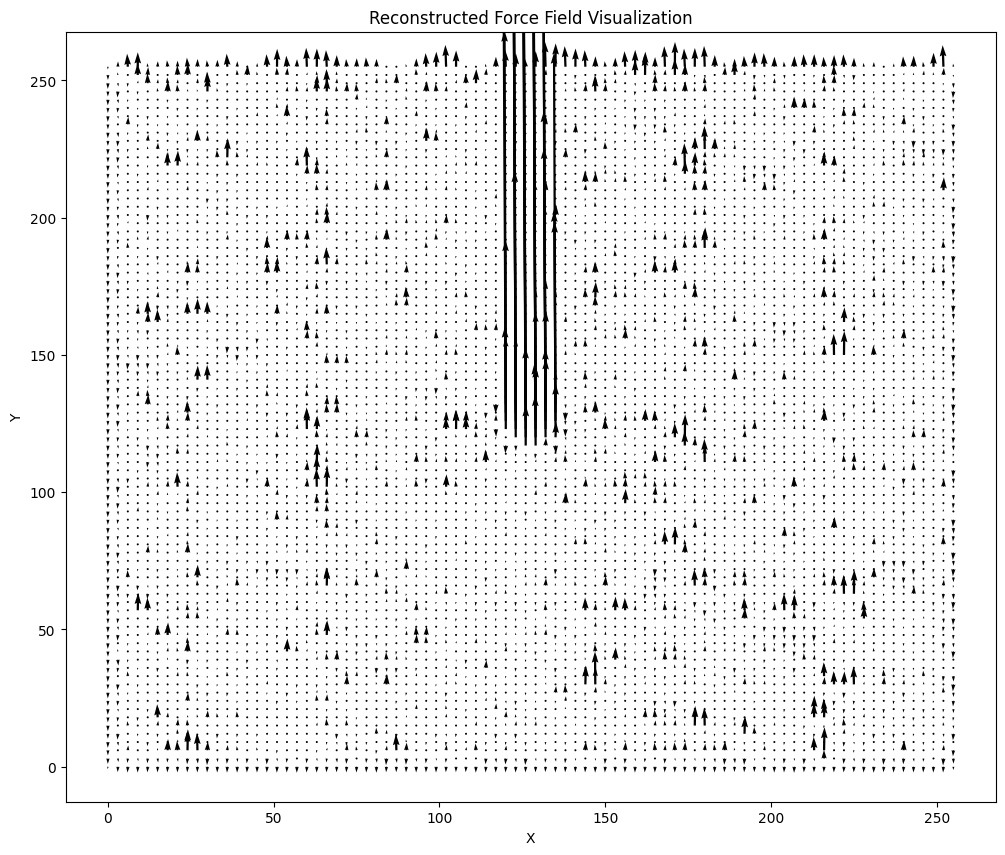

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming your data is stored in a variable called 'forces'
# forces.shape should be (2, 256, 256)

x = np.arange(0, 256)
y = np.arange(0, 256)
X, Y = np.meshgrid(x, y)

# Downsample for clarity if needed
step = 3  # Adjust this to change density of arrows
plt.figure(figsize=(12, 10))
plt.quiver(X[::step, ::step], Y[::step, ::step], 
           outputs[0, 0, ::step, ::step].cpu(), outputs[0, 1, ::step, ::step].cpu())
plt.title('Reconstructed Force Field Visualization')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

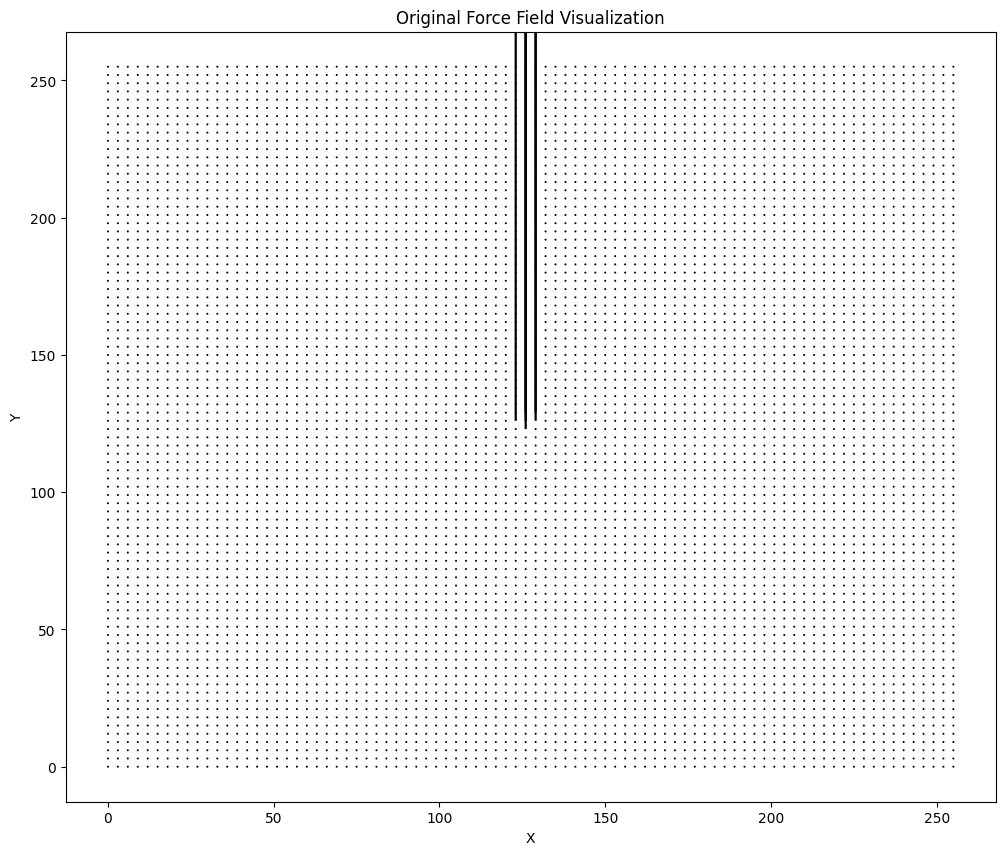

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming your data is stored in a variable called 'forces'
# forces.shape should be (2, 256, 256)

x = np.arange(0, 256)
y = np.arange(0, 256)
X, Y = np.meshgrid(x, y)

# Downsample for clarity if needed
step = 3  # Adjust this to change density of arrows
plt.figure(figsize=(12, 10))
plt.quiver(X[::step, ::step], Y[::step, ::step], 
           forces[500, 0, ::step, ::step], forces[500, 1, ::step, ::step])
plt.title('Original Force Field Visualization')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()